# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и первое знакомство с данными

Загрузим фаил с данными и проведём первичное знакомство с ними.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
# Импортируем библиотеки

In [2]:
df = pd.read_csv ('/datasets/autos.csv')

Создадим функцию для первичного знакомства с данными

In [3]:
def first_look (df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2), '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print ('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    # ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
            print('')
    print('------------- Категориальные признаки ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

In [4]:
first_look(df)

------------- Первые 5 строк ------------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 n

**Вывод**

Перед нами датафрейм состоящий из 16 столбцов и 354369 строк. 

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

Обнаружено 4 дубликата, их просто удалим. 
Некоторые столбцы имеют пропуски, разберёмся, что с ними делать:

- VehicleType мы заполнить не можем, даже одна и та же модель может иметь разные типы кузовов и это значимый фактор влияющий на цену автомобиля, просто удалим.
- Gearbox, Model, FuelType, NotRepaired мы тоже заполнить не можем все эти факторы влияют на цену автомобиля и невозможно выявить зависимость их, от других факторов

### Работа с пропусками и дубликатами

Заполним пропуски в столбце "NotRepaired" значениями "no" по всей видимости могли не указать отсутствие ремонта.
В столбце "VehicleType" пропуски заполним значением "not_specified" (не указан).
Остальные пропуски просто удлим.

In [5]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')
df['VehicleType'] = df['VehicleType'].fillna('not_specified')
df = df.dropna().reset_index(drop=True)

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

**Вывод**

Удалили дубликаты, заполнили пропуски в столбце (NotRepaired) и (VehicleType), остальные пропуски удалили.

### Определение значимых признаков

Для определения цены автомобиля, значимыми признаками являются: тип автомобильного кузова (VehicleType), год регистрации автомобиля (RegistrationYear), тип коробки передач (Gearbox), мощность (Power), модель автомобиля (Model), пробег (Kilometer), тип топлива (FuelType), марка автомобиля (Brand), была машина в ремонте или нет (NotRepaired). Эти признаки оставим, остальные столбцы удалим.  

Кроме того удалим столбец количество фотографий автомобиля (NumberOfPictures), т.к. там только одно значение "0". По всей видимости приложение не предусматривает добавление фотографий, есть над чем работать. 

In [7]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

In [8]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,not_specified,1993,manual,0,golf,150000,petrol,volkswagen,no
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Вывод** В датафрейме оставили только те признаки, которые влияют на стоимость автомобиля.

### Взгляд на данные после первичной предобработки

Снова взглянем на данные после первичной обработки

In [9]:
first_look(df)

------------- Первые 5 строк ------------


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,not_specified,1993,manual,0,golf,150000,petrol,volkswagen,no
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 299223 entries, 0 to 299227
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             299223 non-null  int64 
 1   VehicleType       299223 non-null  object
 2   RegistrationYear  299223 non-null  int64 
 3   Gearbox           299223 non-null  object
 4   Power             299223 non-null  int64 
 5   Model             299223 non-null  object
 6   Kilometer         299223 non-null  int64 
 7   FuelType          299223 non-null  object
 8   Brand             299223 non-null  object
 9   NotRepaired       299223 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.1+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов:  47572


















------------- Категориальные признаки ------------
VehicleType :  9 категории -  ['not_specified' 's

### Вывод

Данные прошли первичную предобработку. В результате проделанных выше действий у нас получился датафрейм состоящий из 10 столбцов и 299223 строки. Не содержащий пропуски и дубликаты.

## Статистический анализ даных

Посмотрим по внимательней на полученные данные

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,299223.000000,299223.000000,299223.000000,299223.000000
mean,4743.272265,2003.206903,115.846466,128490.373400
std,4604.413622,24.504382,172.614757,36696.673076
min,0.000000,1000.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,75.000000,125000.000000
50%,3000.000000,2003.000000,108.000000,150000.000000
75%,6900.000000,2007.000000,144.000000,150000.000000
max,20000.000000,9000.000000,20000.000000,150000.000000


Первичный взгляд на данные вызывает ряд вопросов:
- Наличие бесплатных автомобилей (скорее всего какая то ошибка с занесением данных)
- Год регистрации автомобиля 1910, тоже сомнительно
- Мощность: не бывает автомобилей с мощностью 20 тыс лошадиных сил да и минимальное значение 0 тоже вызывает вопросы

Будем постепенно разбиратся.

Ограничим минимальную мощность 50 л.с., минимальную цену 100 евро (врятли можно купить автомобиль дешевле) кроме того ограничим максимальноу мощность 600 л.с. (гражданских автомобилей с большей мощностью практически не существует) и год регистрации возьмём больше 1980.

In [11]:
df = df.query('Price > 100').reset_index(drop=True)
df = df.query('Power < 600').reset_index(drop=True)
df = df.query('Power > 50').reset_index(drop=True)
df = df.query('2022 >= RegistrationYear >= 1980').reset_index(drop=True)

Теперь построим гистограммы количества объявлений по указанным выше показателям.

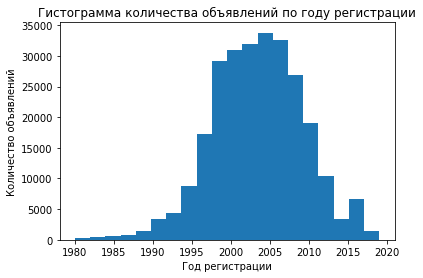

In [12]:
plt.hist(df['RegistrationYear'], bins=20)
plt.title('Гистограмма количества объявлений по году регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Количество объявлений')
plt.show()

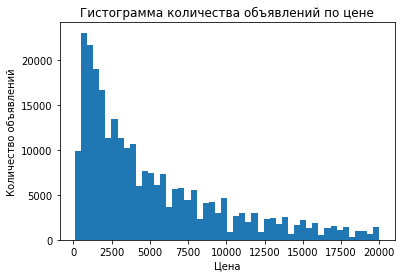

In [13]:
plt.hist(df['Price'], bins=50)
plt.title('Гистограмма количества объявлений по цене')
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')
plt.show()

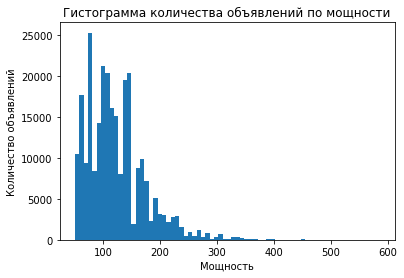

In [14]:
plt.hist(df['Power'], bins=70)
plt.title('Гистограмма количества объявлений по мощности')
plt.xlabel('Мощность')
plt.ylabel('Количество объявлений')
plt.show()

Снова взглянем на данные

In [15]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,263732.000000,263732.000000,263732.000000,263732.000000
mean,5107.145674,2003.556652,123.586823,128237.036082
std,4644.924976,5.950558,52.368277,36480.515901
min,101.000000,1980.000000,51.000000,5000.000000
25%,1500.000000,1999.000000,84.000000,125000.000000
50%,3500.000000,2004.000000,116.000000,150000.000000
75%,7400.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,585.000000,150000.000000


### Вывод

После всех преобразований, мы получили средний автомобиль: зарегистрирован в 2004 году, мощностью 116 л.с с пробегом 150 тыс км и ценой около 5000 Евро.

## Обучение моделей

### Разделение датафрейма на тренировочную, валидационную и тестовую выборки

Сначала разделим данные на целлевые и признаки

In [16]:
features = df.drop(['Price'], axis=1)
target = df['Price']

Теперь подготовим признаки

In [17]:
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer']

#### Кодирование данных для случайного леса

Прямое кодирование категорильных признаков

In [18]:
encoder = OrdinalEncoder()
encoder.fit(features[category])
features_ordinal = pd.DataFrame(encoder.fit_transform(features[category]), columns=features[category].columns)
features_ordinal.head(10)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,7.0,0.0,116.0,2.0,14.0,0.0
1,6.0,1.0,115.0,6.0,37.0,0.0
2,6.0,1.0,100.0,2.0,31.0,0.0
3,5.0,1.0,11.0,6.0,2.0,1.0
4,1.0,1.0,8.0,6.0,25.0,0.0
5,0.0,1.0,59.0,6.0,10.0,0.0
6,5.0,1.0,10.0,6.0,19.0,0.0
7,8.0,1.0,169.0,2.0,37.0,1.0
8,8.0,1.0,169.0,6.0,37.0,0.0
9,7.0,1.0,158.0,2.0,23.0,0.0


In [19]:
feature_numeric = features[numeric]
features_coded = features_ordinal.join(feature_numeric)
features_coded.head(10)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Kilometer
0,7.0,0.0,116.0,2.0,14.0,0.0,2004,163,125000
1,6.0,1.0,115.0,6.0,37.0,0.0,2001,75,150000
2,6.0,1.0,100.0,2.0,31.0,0.0,2008,69,90000
3,5.0,1.0,11.0,6.0,2.0,1.0,1995,102,150000
4,1.0,1.0,8.0,6.0,25.0,0.0,2004,109,150000
5,0.0,1.0,59.0,6.0,10.0,0.0,2014,125,30000
6,5.0,1.0,10.0,6.0,19.0,0.0,2004,105,150000
7,8.0,1.0,169.0,2.0,37.0,1.0,2005,140,150000
8,8.0,1.0,169.0,6.0,37.0,0.0,1995,115,150000
9,7.0,1.0,158.0,2.0,23.0,0.0,2011,190,70000


#### Разбивка данных на выборки для случайного леса

In [20]:
features_forest_train, features_forest_valid, target_forest_train, target_forest_valid = train_test_split(
    features_coded, target, test_size=0.40, random_state=12345)
# Отделяем обучающую выборку
features_forest_test, features_forest_valid, target_forest_test, target_forest_valid = train_test_split(
    features_forest_valid, target_forest_valid, test_size=0.50, random_state=12345)

#### Масштабирование признаков для случайного леса

In [21]:
scaler = StandardScaler()
scaler.fit(features_forest_train)

features_scaled = scaler.transform(features_forest_train)
features_forest_train = pd.DataFrame(features_scaled, columns=features_coded.columns)

features_valid_scaled = scaler.transform(features_forest_valid)
features_forest_valid = pd.DataFrame(features_valid_scaled, columns=features_coded.columns)

features_test_scaled = scaler.transform(features_forest_test)
features_forest_test = pd.DataFrame(features_test_scaled, columns=features_coded.columns)

In [22]:
print('Размер тренировочной выборки', features_forest_train.shape)
print('Размер тестовой выборки', features_forest_valid.shape)
print('Размер валидационной выборки', features_forest_test.shape)

Размер тренировочной выборки (158239, 9)
Размер тестовой выборки (52747, 9)
Размер валидационной выборки (52746, 9)


**Вывод** Подготовили признаки к обучению моделей случайного леса и разбили выборки на тренировочную валидационную и тестовую.

#### Кодирование данных для моделей регрессии

Применим для категорильных признаков метод прямого кодирования

In [23]:
df_ohe = pd.get_dummies(df, drop_first=True)
target_regression = df_ohe['Price']
features_regression = df_ohe.drop('Price', axis=1)

#### Разбивка данных на выборки для регрессии

In [24]:
features_regression_train, features_regression_valid, target_regression_train, target_regression_valid = train_test_split(
    features_regression, target_regression, test_size=0.40, random_state=12345)
# Отделяем обучающую выборку
features_regression_test, features_regression_valid, target_regression_test, target_regression_valid = train_test_split(
    features_regression_valid, target_regression_valid, test_size=0.50, random_state=12345)

#### Масштабирование признаков для регрессии

In [25]:
scaler = StandardScaler()
scaler.fit(features_regression_train)

features_scaled = scaler.transform(features_regression_train)
features_regression_train = pd.DataFrame(features_scaled, columns=features_regression.columns)

features_valid_scaled = scaler.transform(features_regression_valid)
features_regression_valid = pd.DataFrame(features_valid_scaled, columns=features_regression.columns)

features_test_scaled = scaler.transform(features_regression_test)
features_regression_test = pd.DataFrame(features_test_scaled, columns=features_regression.columns)

In [26]:
print('Размер тренировочной выборки', features_regression_train.shape)
print('Размер тестовой выборки', features_regression_test.shape)
print('Размер валидационной выборки', features_regression_valid.shape)

Размер тренировочной выборки (158239, 303)
Размер тестовой выборки (52746, 303)
Размер валидационной выборки (52747, 303)


### Модель случайного леса

In [27]:
randomforest_rmse = []
for est in range(1, 71,10):
    for depth in range (1, 11):
        model_RandomForest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_RandomForest.fit( features_forest_train, target_forest_train)
        predictions_valid = model_RandomForest.predict(features_forest_valid)
        randomforest_rmse.append((mean_squared_error(target_forest_valid, predictions_valid)**0.5, depth, est))
print('Минимальное значение RMSE:', min(randomforest_rmse))

Минимальное значение RMSE: (1849.0481657548264, 10, 61)


Посмотрим производительность на лучшей модели: Это модель с гиперпараметрами n_estimators = 61, max_depth = 10.

In [28]:
%%time
model_RandomForest = RandomForestRegressor(random_state=12345, n_estimators=61, max_depth=10)
model_RandomForest.fit( features_forest_train, target_forest_train)

CPU times: user 10.2 s, sys: 24 ms, total: 10.2 s
Wall time: 10.2 s


RandomForestRegressor(max_depth=10, n_estimators=61, random_state=12345)

In [29]:
%%time
predictions_valid = model_RandomForest.predict(features_forest_valid)
print('Значение RMSE:', mean_squared_error(target_forest_valid, predictions_valid)**0.5)

Значение RMSE: 1849.0481657548264
CPU times: user 272 ms, sys: 1 µs, total: 272 ms
Wall time: 276 ms


**Вывод** Лучшее значение RMSE (1849,04) получилось при значениях гиперпараметров n_estimators = 61, max_depth = 10. По требованию клиента нам подходит эта модель. Время обучения составило 12 сек, время предсказания 0.31 сек.

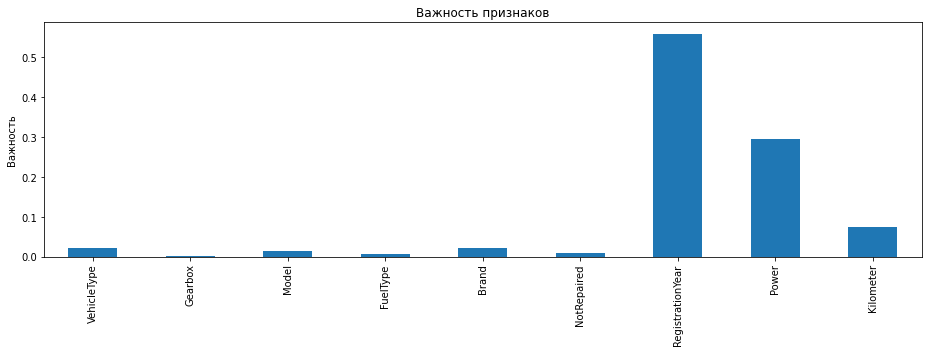

In [30]:
RandomForest_imp = pd.Series(model_RandomForest.feature_importances_,
                         features_forest_train.columns)
fig, ax = plt.subplots(figsize=(13,5))
RandomForest_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Получается, что самые важные признаки это год регистрации мощность и пробег.

### Модель линейной регрессии

In [32]:
%%time
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(features_regression_train, target_regression_train)

CPU times: user 10.6 s, sys: 4.88 s, total: 15.5 s
Wall time: 16.9 s


LinearRegression()

In [33]:
%%time
predictions = model_LinearRegression.predict(features_regression_valid)
print('RMSE для модели линейной регрессии:', mean_squared_error(target_regression_valid, predictions)**0.5)

RMSE для модели линейной регрессии: 2369.9759145668913
CPU times: user 56.7 ms, sys: 24.4 ms, total: 81.1 ms
Wall time: 96.4 ms


**Вывод** Мы получили RMSE для линейной регрессии 2369.97. Время обучения 61 мс время получения предсказания 4.04 мс. Эта модель нам не подходит по требованию клиента.  

### Градиендный бустинг CatBoost

Обучим модель градиендного бустинга (CatBoost) с гиперпараметром : iterations 10; 50 и 100 соответственно и посмотрим RMSE.

In [34]:
%%time
model_CatBoost = CatBoostRegressor(loss_function="RMSE", iterations=10)
model_CatBoost.fit(features_forest_train, target_forest_train, verbose=10)

Learning rate set to 0.5
0:	learn: 3271.7455015	total: 71.1ms	remaining: 640ms
9:	learn: 1931.0378173	total: 231ms	remaining: 0us
CPU times: user 251 ms, sys: 47.5 ms, total: 298 ms
Wall time: 918 ms


In [35]:
%%time
predictions = model_CatBoost.predict(features_forest_valid)
print('RMSE для градиендного бустинга (CatBoost) (iterations=10):', mean_squared_error(target_forest_valid, predictions)**0.5)

RMSE для градиендного бустинга (CatBoost) (iterations=10): 1931.926845711799
CPU times: user 581 µs, sys: 7.78 ms, total: 8.36 ms
Wall time: 6.83 ms


In [36]:
%%time
model_CatBoost = CatBoostRegressor(loss_function="RMSE", iterations=50)
model_CatBoost.fit(features_forest_train, target_forest_train, verbose=10)

Learning rate set to 0.5
0:	learn: 3271.7455015	total: 23.8ms	remaining: 1.16s
10:	learn: 1914.6712855	total: 205ms	remaining: 728ms
20:	learn: 1796.9138987	total: 388ms	remaining: 536ms
30:	learn: 1738.4579386	total: 571ms	remaining: 350ms
40:	learn: 1699.2834767	total: 755ms	remaining: 166ms
49:	learn: 1674.6097737	total: 919ms	remaining: 0us
CPU times: user 996 ms, sys: 15.9 ms, total: 1.01 s
Wall time: 1.42 s


In [37]:
%%time
predictions = model_CatBoost.predict(features_forest_valid)
print('RMSE для градиендного бустинга (CatBoost) (iterations=50):', mean_squared_error(target_forest_valid, predictions)**0.5)

RMSE для градиендного бустинга (CatBoost) (iterations=50): 1707.5436691546038
CPU times: user 10.4 ms, sys: 69 µs, total: 10.4 ms
Wall time: 8.45 ms


In [38]:
%%time
model_CatBoost = CatBoostRegressor(loss_function="RMSE", iterations=100)
model_CatBoost.fit(features_forest_train, target_forest_train, verbose=10)

Learning rate set to 0.5
0:	learn: 3271.7455015	total: 22.8ms	remaining: 2.26s
10:	learn: 1914.6712855	total: 205ms	remaining: 1.65s
20:	learn: 1796.9138987	total: 385ms	remaining: 1.45s
30:	learn: 1738.4579386	total: 565ms	remaining: 1.26s
40:	learn: 1699.2834767	total: 742ms	remaining: 1.07s
50:	learn: 1671.5390354	total: 918ms	remaining: 882ms
60:	learn: 1646.0740663	total: 1.11s	remaining: 709ms
70:	learn: 1625.4693588	total: 1.32s	remaining: 538ms
80:	learn: 1605.9647173	total: 1.5s	remaining: 353ms
90:	learn: 1593.3153000	total: 1.68s	remaining: 167ms
99:	learn: 1581.9327522	total: 1.84s	remaining: 0us
CPU times: user 1.92 s, sys: 23.4 ms, total: 1.94 s
Wall time: 2.35 s


In [39]:
%%time
predictions = model_CatBoost.predict(features_forest_valid)
print('RMSE для градиендного бустинга (CatBoost) (iterations=100):', mean_squared_error(target_forest_valid, predictions)**0.5)

RMSE для градиендного бустинга (CatBoost) (iterations=100): 1636.2000443994898
CPU times: user 12.2 ms, sys: 72 µs, total: 12.3 ms
Wall time: 10.6 ms


**Вывод** Лучший результат RMSE 1636.2 показала модель c гиперпараметром iterations=100. Время обучения 2.46 сек, время предсказания 13 мс. 

### Градиендный бустинг LightGBM

In [40]:
LightGBM_rmse = []
for est in range(1, 71,10):
    for depth in range (1, 11):
        model_LightGBM = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_LightGBM.fit(features_forest_train, target_forest_train)
        predictions_valid = model_LightGBM.predict(features_forest_valid)
        LightGBM_rmse.append((mean_squared_error(target_forest_valid, predictions_valid)**0.5, depth, est))
print('Минимальное значение RMSE модели LightGBM :', min(LightGBM_rmse))

Минимальное значение RMSE модели LightGBM : (1730.9574157923562, 10, 61)


In [41]:
%%time
model_LightGBM = LGBMRegressor(random_state=12345, n_estimators=61, max_depth=10)
model_LightGBM.fit(features_forest_train, target_forest_train)

CPU times: user 2.69 s, sys: 4.57 ms, total: 2.7 s
Wall time: 2.7 s


LGBMRegressor(max_depth=10, n_estimators=61, random_state=12345)

In [42]:
%%time
predictions_valid = model_LightGBM.predict(features_forest_valid)
print('Значение RMSE модели LightGBM :', mean_squared_error(target_forest_valid, predictions_valid)**0.5)

Значение RMSE модели LightGBM : 1730.9574157923562
CPU times: user 247 ms, sys: 3.1 ms, total: 250 ms
Wall time: 203 ms


**Вывдо** Минимальное значение RMSE 1730.95 модели LightGBM получилось при параметрах n_estimators = 61 и max_depth = 10. Время обучения 29.6 сек время предсказания 0.28 сек.    

### Вывод

Мы обучили 4 модели и для каждой посмотрели RMSE На валидационной выборки. Модель линейной регрессии нам не подходят по требованиям клиента. 

- Модель слечайного леса: лучшее значение RMSE (1868,07) получилось при значениях гиперпараметров n_estimators = 61, max_depth = 10.
- Модель градиендного бустинга CatBoost: лучший результат RMSE 1636.2 показала модель c гиперпараметром iterations=100.
- Модель градиендного бустинга LightGBM: лучший результат RMSE 1730.95 Модели LightGBM получилось при параметрах n_estimators = 61 и max_depth = 10

Лучший результат показала модель CatBoost, её и протестируем в дальнейшем.

## Анализ моделей

### Градиендный бустинг CatBoost

In [47]:
%%time
model_CatBoost = CatBoostRegressor(loss_function="RMSE", iterations=100)
model_CatBoost.fit(features_forest_train, target_forest_train, verbose=10)
predictions = model_CatBoost.predict(features_forest_test)
print('RMSE для градиендного бустинга (CatBoost) (iterations=100) на тестовой выборке:', mean_squared_error(target_forest_test, predictions)**0.5)

Learning rate set to 0.5
0:	learn: 3271.7455015	total: 25.4ms	remaining: 2.51s
10:	learn: 1914.6712855	total: 217ms	remaining: 1.75s
20:	learn: 1796.9138987	total: 406ms	remaining: 1.53s
30:	learn: 1738.4579386	total: 600ms	remaining: 1.33s
40:	learn: 1699.2834767	total: 789ms	remaining: 1.14s
50:	learn: 1671.5390354	total: 982ms	remaining: 943ms
60:	learn: 1646.0740663	total: 1.17s	remaining: 750ms
70:	learn: 1625.4693588	total: 1.36s	remaining: 558ms
80:	learn: 1605.9647173	total: 1.55s	remaining: 365ms
90:	learn: 1593.3153000	total: 1.74s	remaining: 172ms
99:	learn: 1581.9327522	total: 1.91s	remaining: 0us
RMSE для градиендного бустинга (CatBoost) (iterations=100) на тестовой выборке: 1617.9783758399722
CPU times: user 2 s, sys: 28.2 ms, total: 2.02 s
Wall time: 2.54 s


## Вывод

В процессе исследования мы построили 4 модели для определения стоимости подержаного автомобиля.
Требованиям клиента, а именно: значение метрики RMSE должно быть меньше 2500, удовлетворили 3 модели:

- Модель слечайного леса: лучшее значение RMSE (1849.04) получилось при значениях гиперпараметров n_estimators = 61, max_depth = 10.
- Модель градиендного бустинга CatBoost: лучший результат RMSE 1636.2 показала модель c гиперпараметром iterations=100.
- Модель градиендного бустинга LightGBM: лучший результат RMSE 1730.95 Модели LightGBM получилось при параметрах n_estimators = 61 и max_depth = 10


Лучшую производительность показала модель радиендного бустинга CatBoost: Время обучения 2.46 сек, время предсказания 13 мс. Модели слечайного леса и градиендный бустинга показали результаты хуже.

Клиенту будем рекомендовать Модель градиендного бустинга CatBoost c гиперпараметром iterations=100, которая показала на тестовой выборке результат: RMSE 1618.